# Cliff Walking with TDL and SARSA

<img src="cliffwalk-annotated.png" style="height:400px">

In [1]:
import numpy as np
from agent import Agent
from environment import Environment
from rlglue import RLGlue
import time
from manager import Manager

In [2]:
class CliffWalking(Environment):
    def env_init(self, env_info={}):
        reward = None
        state = None 
        is_terminal = None
        self.reward_state_term = (reward, state, is_terminal)

        self.grid_h = env_info.get("grid_height", 4) 
        self.grid_w = env_info.get("grid_width", 12)

        self.start_state = (self.grid_h - 1, 0)
        self.end_state = (self.grid_h - 1, self.grid_w - 1)
        self.cliff = [(self.grid_h - 1, i) for i in range(1, (self.grid_w - 1))]

    def env_start(self):
        reward = 0
        self.current_state = self.start_state
        state = self.env_state(self.current_state)
        is_terminal = False
        self.reward_state_term = (reward, state, is_terminal)
        return self.reward_state_term[1]

    def env_step(self, action):
        if action == 0: 
            if self.current_state[0] > 0: 
                self.current_state = (self.current_state[0] - 1, self.current_state[1])
        elif action == 1: 
            possible_next_state = (self.current_state[0], self.current_state[1] - 1)
            if possible_next_state[1] >= 0: 
                self.current_state = possible_next_state
            else:
                pass 
        elif action == 2: 
            possible_next_state = (self.current_state[0] + 1, self.current_state[1])
            if possible_next_state[0] < self.grid_h: 
                self.current_state = possible_next_state
            else:
                pass 
        elif action == 3: 
            possible_next_state = (self.current_state[0], self.current_state[1] + 1)
            if possible_next_state[1] < self.grid_w: 
                self.current_state = possible_next_state
            else:
                pass 
        else: 
            raise Exception(str(action) + " not in recognized actions [0: Up, 1: Left, 2: Down, 3: Right]!")

        reward = -1
        is_terminal = False

        if self.current_state == self.end_state: 
            is_terminal = True
        elif self.current_state in self.cliff: 
            reward = -100
            self.current_state = self.start_state
        else: 
            pass  

        self.reward_state_term = (reward, self.env_state(self.current_state), is_terminal)
        return self.reward_state_term
        
    def env_cleanup(self):
        self.current_state = None
    
    def env_state(self, state):
        return state[0]*self.grid_w + state[1]

In [3]:
class TDL(Agent):
    def agent_init(self, agent_info={}):
        self.discount = agent_info.get("discount")
        self.step_size = agent_info.get("step_size")
        self.policy = agent_info.get("policy")
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        self.v = np.zeros((self.policy.shape[0],))
        
    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state
        return action

    def agent_step(self, reward, state):        
        target = reward + self.discount*self.v[state]
        self.v[self.last_state] = self.v[self.last_state] + self.step_size*(target-self.v[self.last_state])
        
        action = self.agent_action(state)
        self.last_state = state
        return action

    def agent_end(self, reward):
        target = reward
        self.v[self.last_state] = self.v[self.last_state] + self.step_size*(target-self.v[self.last_state])

    def agent_cleanup(self):
        self.last_state = None
                    
    def agent_action(self, state):
        return self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])

In [4]:
class PolicyEvaluation(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode) 
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
        self.rl_cleanup()
        return self.agent.v

-----

In [5]:
env_info = {"grid_height": 4, 
            "grid_width": 12}

cliff_walking = CliffWalking()

In [6]:
safe_policy = np.ones(shape=(env_info['grid_width']*env_info['grid_height'], 4)) * 0.25
for i in range(0, 11):
    safe_policy[i] = [0, 0, 0, 1]
safe_policy[11] = [0, 0, 1, 0]
safe_policy[12] = [1, 0, 0, 0]
safe_policy[23] = [0, 0, 1, 0]
safe_policy[24] = [1, 0, 0, 0]
safe_policy[35] = [0, 0, 1, 0]
safe_policy[36] = [1, 0, 0, 0]

agent_info = {"discount": 1.,
              "step_size": 0.01, 
              "policy": safe_policy}

tdl = TDL()

In [7]:
num_episodes = 5000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=cliff_walking, agent=tdl)
v = policy_evaluation.rl_run(env_info=env_info, 
                             agent_info=agent_info, 
                             num_episodes=num_episodes, 
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 17
----- 0.001s -----
Episode: 2/5000 - Steps: 17
----- 0.0s -----
Episode: 3/5000 - Steps: 17
----- 0.0s -----
Episode: 4/5000 - Steps: 17
----- 0.0s -----
Episode: 5/5000 - Steps: 17
----- 0.0s -----
Episode: 6/5000 - Steps: 17
----- 0.0s -----
Episode: 7/5000 - Steps: 17
----- 0.0s -----
Episode: 8/5000 - Steps: 17
----- 0.0s -----
Episode: 9/5000 - Steps: 17
----- 0.0s -----
Episode: 10/5000 - Steps: 17
----- 0.0s -----
Episode: 11/5000 - Steps: 17
----- 0.0s -----
Episode: 12/5000 - Steps: 17
----- 0.0s -----
Episode: 13/5000 - Steps: 17
----- 0.0s -----
Episode: 14/5000 - Steps: 17
----- 0.0s -----
Episode: 15/5000 - Steps: 17
----- 0.0s -----
Episode: 16/5000 - Steps: 17
----- 0.0s -----
Episode: 17/5000 - Steps: 17
----- 0.0s -----
Episode: 18/5000 - Steps: 17
----- 0.0s -----
Episode: 19/5000 - Steps: 17
----- 0.0s -----
Episode: 20/5000 - Steps: 17
----- 0.0s -----
Episode: 21/5000 - Steps: 17
----- 0.0s -----
Episode: 22/5000 - Steps: 17
----- 0.0s -

Episode: 724/5000 - Steps: 17
----- 0.0s -----
Episode: 725/5000 - Steps: 17
----- 0.0s -----
Episode: 726/5000 - Steps: 17
----- 0.0s -----
Episode: 727/5000 - Steps: 17
----- 0.0s -----
Episode: 728/5000 - Steps: 17
----- 0.0s -----
Episode: 729/5000 - Steps: 17
----- 0.0s -----
Episode: 730/5000 - Steps: 17
----- 0.0s -----
Episode: 731/5000 - Steps: 17
----- 0.0s -----
Episode: 732/5000 - Steps: 17
----- 0.0s -----
Episode: 733/5000 - Steps: 17
----- 0.0s -----
Episode: 734/5000 - Steps: 17
----- 0.0s -----
Episode: 735/5000 - Steps: 17
----- 0.0s -----
Episode: 736/5000 - Steps: 17
----- 0.0s -----
Episode: 737/5000 - Steps: 17
----- 0.0s -----
Episode: 738/5000 - Steps: 17
----- 0.0s -----
Episode: 739/5000 - Steps: 17
----- 0.0s -----
Episode: 740/5000 - Steps: 17
----- 0.0s -----
Episode: 741/5000 - Steps: 17
----- 0.0s -----
Episode: 742/5000 - Steps: 17
----- 0.0s -----
Episode: 743/5000 - Steps: 17
----- 0.0s -----
Episode: 744/5000 - Steps: 17
----- 0.0s -----
Episode: 745/

Episode: 1227/5000 - Steps: 17
----- 0.0s -----
Episode: 1228/5000 - Steps: 17
----- 0.0s -----
Episode: 1229/5000 - Steps: 17
----- 0.0s -----
Episode: 1230/5000 - Steps: 17
----- 0.0s -----
Episode: 1231/5000 - Steps: 17
----- 0.0s -----
Episode: 1232/5000 - Steps: 17
----- 0.0s -----
Episode: 1233/5000 - Steps: 17
----- 0.0s -----
Episode: 1234/5000 - Steps: 17
----- 0.0s -----
Episode: 1235/5000 - Steps: 17
----- 0.0s -----
Episode: 1236/5000 - Steps: 17
----- 0.0s -----
Episode: 1237/5000 - Steps: 17
----- 0.0s -----
Episode: 1238/5000 - Steps: 17
----- 0.0s -----
Episode: 1239/5000 - Steps: 17
----- 0.0s -----
Episode: 1240/5000 - Steps: 17
----- 0.0s -----
Episode: 1241/5000 - Steps: 17
----- 0.0s -----
Episode: 1242/5000 - Steps: 17
----- 0.0s -----
Episode: 1243/5000 - Steps: 17
----- 0.0s -----
Episode: 1244/5000 - Steps: 17
----- 0.0s -----
Episode: 1245/5000 - Steps: 17
----- 0.0s -----
Episode: 1246/5000 - Steps: 17
----- 0.0s -----
Episode: 1247/5000 - Steps: 17
----- 0.0

Episode: 1832/5000 - Steps: 17
----- 0.0s -----
Episode: 1833/5000 - Steps: 17
----- 0.0s -----
Episode: 1834/5000 - Steps: 17
----- 0.0s -----
Episode: 1835/5000 - Steps: 17
----- 0.0s -----
Episode: 1836/5000 - Steps: 17
----- 0.0s -----
Episode: 1837/5000 - Steps: 17
----- 0.0s -----
Episode: 1838/5000 - Steps: 17
----- 0.0s -----
Episode: 1839/5000 - Steps: 17
----- 0.0s -----
Episode: 1840/5000 - Steps: 17
----- 0.0s -----
Episode: 1841/5000 - Steps: 17
----- 0.0s -----
Episode: 1842/5000 - Steps: 17
----- 0.0s -----
Episode: 1843/5000 - Steps: 17
----- 0.0s -----
Episode: 1844/5000 - Steps: 17
----- 0.0s -----
Episode: 1845/5000 - Steps: 17
----- 0.0s -----
Episode: 1846/5000 - Steps: 17
----- 0.0s -----
Episode: 1847/5000 - Steps: 17
----- 0.0s -----
Episode: 1848/5000 - Steps: 17
----- 0.0s -----
Episode: 1849/5000 - Steps: 17
----- 0.0s -----
Episode: 1850/5000 - Steps: 17
----- 0.0s -----
Episode: 1851/5000 - Steps: 17
----- 0.0s -----
Episode: 1852/5000 - Steps: 17
----- 0.0

----- 0.0s -----
Episode: 2477/5000 - Steps: 17
----- 0.0s -----
Episode: 2478/5000 - Steps: 17
----- 0.0s -----
Episode: 2479/5000 - Steps: 17
----- 0.0s -----
Episode: 2480/5000 - Steps: 17
----- 0.0s -----
Episode: 2481/5000 - Steps: 17
----- 0.0s -----
Episode: 2482/5000 - Steps: 17
----- 0.0s -----
Episode: 2483/5000 - Steps: 17
----- 0.0s -----
Episode: 2484/5000 - Steps: 17
----- 0.0s -----
Episode: 2485/5000 - Steps: 17
----- 0.0s -----
Episode: 2486/5000 - Steps: 17
----- 0.0s -----
Episode: 2487/5000 - Steps: 17
----- 0.0s -----
Episode: 2488/5000 - Steps: 17
----- 0.0s -----
Episode: 2489/5000 - Steps: 17
----- 0.0s -----
Episode: 2490/5000 - Steps: 17
----- 0.0s -----
Episode: 2491/5000 - Steps: 17
----- 0.0s -----
Episode: 2492/5000 - Steps: 17
----- 0.0s -----
Episode: 2493/5000 - Steps: 17
----- 0.0s -----
Episode: 2494/5000 - Steps: 17
----- 0.0s -----
Episode: 2495/5000 - Steps: 17
----- 0.0s -----
Episode: 2496/5000 - Steps: 17
----- 0.0s -----
Episode: 2497/5000 - St

----- 0.0s -----
Episode: 3098/5000 - Steps: 17
----- 0.0s -----
Episode: 3099/5000 - Steps: 17
----- 0.0s -----
Episode: 3100/5000 - Steps: 17
----- 0.0s -----
Episode: 3101/5000 - Steps: 17
----- 0.0s -----
Episode: 3102/5000 - Steps: 17
----- 0.0s -----
Episode: 3103/5000 - Steps: 17
----- 0.0s -----
Episode: 3104/5000 - Steps: 17
----- 0.0s -----
Episode: 3105/5000 - Steps: 17
----- 0.0s -----
Episode: 3106/5000 - Steps: 17
----- 0.0s -----
Episode: 3107/5000 - Steps: 17
----- 0.0s -----
Episode: 3108/5000 - Steps: 17
----- 0.0s -----
Episode: 3109/5000 - Steps: 17
----- 0.0s -----
Episode: 3110/5000 - Steps: 17
----- 0.0s -----
Episode: 3111/5000 - Steps: 17
----- 0.0s -----
Episode: 3112/5000 - Steps: 17
----- 0.0s -----
Episode: 3113/5000 - Steps: 17
----- 0.0s -----
Episode: 3114/5000 - Steps: 17
----- 0.0s -----
Episode: 3115/5000 - Steps: 17
----- 0.0s -----
Episode: 3116/5000 - Steps: 17
----- 0.0s -----
Episode: 3117/5000 - Steps: 17
----- 0.0s -----
Episode: 3118/5000 - St

Episode: 3726/5000 - Steps: 17
----- 0.0s -----
Episode: 3727/5000 - Steps: 17
----- 0.0s -----
Episode: 3728/5000 - Steps: 17
----- 0.0s -----
Episode: 3729/5000 - Steps: 17
----- 0.0s -----
Episode: 3730/5000 - Steps: 17
----- 0.0s -----
Episode: 3731/5000 - Steps: 17
----- 0.0s -----
Episode: 3732/5000 - Steps: 17
----- 0.0s -----
Episode: 3733/5000 - Steps: 17
----- 0.0s -----
Episode: 3734/5000 - Steps: 17
----- 0.0s -----
Episode: 3735/5000 - Steps: 17
----- 0.0s -----
Episode: 3736/5000 - Steps: 17
----- 0.0s -----
Episode: 3737/5000 - Steps: 17
----- 0.0s -----
Episode: 3738/5000 - Steps: 17
----- 0.0s -----
Episode: 3739/5000 - Steps: 17
----- 0.0s -----
Episode: 3740/5000 - Steps: 17
----- 0.0s -----
Episode: 3741/5000 - Steps: 17
----- 0.0s -----
Episode: 3742/5000 - Steps: 17
----- 0.0s -----
Episode: 3743/5000 - Steps: 17
----- 0.0s -----
Episode: 3744/5000 - Steps: 17
----- 0.0s -----
Episode: 3745/5000 - Steps: 17
----- 0.0s -----
Episode: 3746/5000 - Steps: 17
----- 0.0

Episode: 4367/5000 - Steps: 17
----- 0.0s -----
Episode: 4368/5000 - Steps: 17
----- 0.0s -----
Episode: 4369/5000 - Steps: 17
----- 0.0s -----
Episode: 4370/5000 - Steps: 17
----- 0.0s -----
Episode: 4371/5000 - Steps: 17
----- 0.0s -----
Episode: 4372/5000 - Steps: 17
----- 0.0s -----
Episode: 4373/5000 - Steps: 17
----- 0.0s -----
Episode: 4374/5000 - Steps: 17
----- 0.0s -----
Episode: 4375/5000 - Steps: 17
----- 0.0s -----
Episode: 4376/5000 - Steps: 17
----- 0.0s -----
Episode: 4377/5000 - Steps: 17
----- 0.0s -----
Episode: 4378/5000 - Steps: 17
----- 0.0s -----
Episode: 4379/5000 - Steps: 17
----- 0.0s -----
Episode: 4380/5000 - Steps: 17
----- 0.0s -----
Episode: 4381/5000 - Steps: 17
----- 0.0s -----
Episode: 4382/5000 - Steps: 17
----- 0.0s -----
Episode: 4383/5000 - Steps: 17
----- 0.0s -----
Episode: 4384/5000 - Steps: 17
----- 0.0s -----
Episode: 4385/5000 - Steps: 17
----- 0.0s -----
Episode: 4386/5000 - Steps: 17
----- 0.0s -----
Episode: 4387/5000 - Steps: 17
----- 0.0

----- 0.0s -----
Episode: 4976/5000 - Steps: 17
----- 0.0s -----
Episode: 4977/5000 - Steps: 17
----- 0.0s -----
Episode: 4978/5000 - Steps: 17
----- 0.0s -----
Episode: 4979/5000 - Steps: 17
----- 0.0s -----
Episode: 4980/5000 - Steps: 17
----- 0.0s -----
Episode: 4981/5000 - Steps: 17
----- 0.0s -----
Episode: 4982/5000 - Steps: 17
----- 0.0s -----
Episode: 4983/5000 - Steps: 17
----- 0.0s -----
Episode: 4984/5000 - Steps: 17
----- 0.0s -----
Episode: 4985/5000 - Steps: 17
----- 0.0s -----
Episode: 4986/5000 - Steps: 17
----- 0.001s -----
Episode: 4987/5000 - Steps: 17
----- 0.0s -----
Episode: 4988/5000 - Steps: 17
----- 0.0s -----
Episode: 4989/5000 - Steps: 17
----- 0.0s -----
Episode: 4990/5000 - Steps: 17
----- 0.0s -----
Episode: 4991/5000 - Steps: 17
----- 0.0s -----
Episode: 4992/5000 - Steps: 17
----- 0.0s -----
Episode: 4993/5000 - Steps: 17
----- 0.0s -----
Episode: 4994/5000 - Steps: 17
----- 0.001s -----
Episode: 4995/5000 - Steps: 17
----- 0.0s -----
Episode: 4996/5000 

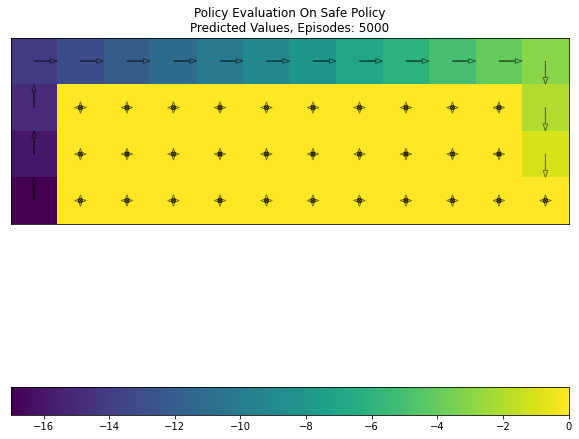

In [8]:
manager = Manager(env_info=env_info, 
             agent_info=agent_info, 
             experiment_name="Policy Evaluation On Safe Policy")
manager.visualize(values=v, num_episodes=num_episodes)

-----

In [9]:
class SARSA(Agent):
    def agent_init(self, agent_info={}):
        self.discount = agent_info.get("discount")
        self.step_size = agent_info.get("step_size")
        self.num_actions = agent_info.get("num_actions")
        self.num_states = agent_info.get("num_states")
        self.epsilon = agent_info.get("epsilon")
        self.decay_factor = agent_info.get("decay_factor")
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        self.q = np.zeros((self.num_states, self.num_actions))
        self.policy = np.ones((self.num_states, self.num_actions))/self.num_actions
        
    def agent_start(self, state):
        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        return action

    def agent_step(self, reward, state):
        action = self.agent_action(state)
        target = reward + self.discount*self.q[state, action]
        self.q[self.last_state, self.last_action] = self.q[self.last_state, self.last_action] + self.step_size*(target-self.q[self.last_state, self.last_action])

        self.agent_improvement(self.last_state)
        
        self.last_state = state
        self.last_action = action
        return action

    def agent_end(self, reward):  
        target = reward
        self.q[self.last_state, self.last_action] = self.q[self.last_state, self.last_action] + self.step_size*(target-self.q[self.last_state, self.last_action])
        
    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None
            
    def agent_action(self, state):
        return self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
    def agent_improvement(self, state):
        self.epsilon = self.decay_factor*self.epsilon

        idx = self.agent_argmax(state)
        
        self.policy[state,:] = 0.
        self.policy[state,idx] = 1.
        p1 = self.epsilon/self.num_actions
        p2 = 1-(self.num_actions-1)*p1
        self.policy[state] = p1*(np.ones(self.num_actions)-self.policy[state]) + p2*self.policy[state]
                
    def agent_argmax(self, state):
        q_max = np.max(self.q[state,:])
        y = 1-np.square(np.sign(self.q[state,:]-q_max))
        y = y/np.sum(y)
        return self.rand_generator.choice(self.num_actions, p=y)

In [10]:
class PolicyIteration(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode) 
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {} - Epsilon: {}'.format(episode+1, num_episodes, self.num_steps, self.agent.epsilon))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
                
        self.rl_cleanup()
        return self.agent.policy

-----

In [11]:
agent_info = {"discount": 1., 
              "step_size": 0.01,  
              "num_states": env_info['grid_width']*env_info['grid_height'], 
              "num_actions": 4, 
              "epsilon": 0.9,
              "decay_factor": 0.9999}

sarsa = SARSA()

In [12]:
num_episodes = 5000
max_steps_this_episode = float('inf')

policy_iteration = PolicyIteration(env=cliff_walking, agent=sarsa)
optimal_policy = policy_iteration.rl_run(env_info=env_info, 
                                         agent_info=agent_info,
                                         num_episodes=num_episodes, 
                                         max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 1309 - Epsilon: 0.7896487472783024
----- 0.047s -----
Episode: 2/5000 - Steps: 579 - Epsilon: 0.7452988901060044
----- 0.021s -----
Episode: 3/5000 - Steps: 1178 - Epsilon: 0.6625390154047006
----- 0.041s -----
Episode: 4/5000 - Steps: 686 - Epsilon: 0.6186724805501916
----- 0.022s -----
Episode: 5/5000 - Steps: 494 - Epsilon: 0.5889101097095536
----- 0.016s -----
Episode: 6/5000 - Steps: 1320 - Epsilon: 0.5161342785991141
----- 0.043s -----
Episode: 7/5000 - Steps: 334 - Epsilon: 0.49922919372249797
----- 0.011s -----
Episode: 8/5000 - Steps: 69 - Epsilon: 0.49584578266745283
----- 0.002s -----
Episode: 9/5000 - Steps: 458 - Epsilon: 0.4736945341281118
----- 0.015s -----
Episode: 10/5000 - Steps: 2253 - Epsilon: 0.37817286671551653
----- 0.073s -----
Episode: 11/5000 - Steps: 221 - Epsilon: 0.3699435070605649
----- 0.007s -----
Episode: 12/5000 - Steps: 765 - Epsilon: 0.3427312081029173
----- 0.025s -----
Episode: 13/5000 - Steps: 59 - Epsilon: 0.3407490218820

Episode: 116/5000 - Steps: 97 - Epsilon: 0.05310405304630052
----- 0.003s -----
Episode: 117/5000 - Steps: 194 - Epsilon: 0.05208892159549493
----- 0.006s -----
Episode: 118/5000 - Steps: 241 - Epsilon: 0.05085360876194632
----- 0.008s -----
Episode: 119/5000 - Steps: 79 - Epsilon: 0.05045847388597835
----- 0.002s -----
Episode: 120/5000 - Steps: 126 - Epsilon: 0.049831637509732844
----- 0.004s -----
Episode: 121/5000 - Steps: 154 - Epsilon: 0.049074978822426805
----- 0.005s -----
Episode: 122/5000 - Steps: 179 - Epsilon: 0.04820912982461886
----- 0.006s -----
Episode: 123/5000 - Steps: 31 - Epsilon: 0.048064711949262734
----- 0.001s -----
Episode: 124/5000 - Steps: 175 - Epsilon: 0.04723557888165723
----- 0.006s -----
Episode: 125/5000 - Steps: 102 - Epsilon: 0.046760877079125414
----- 0.003s -----
Episode: 126/5000 - Steps: 82 - Epsilon: 0.0463836250453317
----- 0.003s -----
Episode: 127/5000 - Steps: 113 - Epsilon: 0.04586700110794694
----- 0.004s -----
Episode: 128/5000 - Steps: 96

Episode: 267/5000 - Steps: 51 - Epsilon: 0.014538328104700196
----- 0.002s -----
Episode: 268/5000 - Steps: 70 - Epsilon: 0.014438353949489151
----- 0.002s -----
Episode: 269/5000 - Steps: 46 - Epsilon: 0.014373524091755258
----- 0.002s -----
Episode: 270/5000 - Steps: 67 - Epsilon: 0.014278966488143634
----- 0.002s -----
Episode: 271/5000 - Steps: 39 - Epsilon: 0.01422480667627107
----- 0.001s -----
Episode: 272/5000 - Steps: 95 - Epsilon: 0.014091713357394032
----- 0.003s -----
Episode: 273/5000 - Steps: 31 - Epsilon: 0.014049499459101203
----- 0.001s -----
Episode: 274/5000 - Steps: 73 - Epsilon: 0.013948701331733145
----- 0.002s -----
Episode: 275/5000 - Steps: 65 - Epsilon: 0.01385971026875542
----- 0.002s -----
Episode: 276/5000 - Steps: 59 - Epsilon: 0.013779552623139565
----- 0.002s -----
Episode: 277/5000 - Steps: 61 - Epsilon: 0.013697118734617066
----- 0.002s -----
Episode: 278/5000 - Steps: 59 - Epsilon: 0.013617901437271183
----- 0.002s -----
Episode: 279/5000 - Steps: 41 

Episode: 368/5000 - Steps: 57 - Epsilon: 0.007918153997595103
----- 0.002s -----
Episode: 369/5000 - Steps: 85 - Epsilon: 0.00785191677791564
----- 0.003s -----
Episode: 370/5000 - Steps: 63 - Epsilon: 0.00780338307711685
----- 0.002s -----
Episode: 371/5000 - Steps: 75 - Epsilon: 0.007745848306773224
----- 0.002s -----
Episode: 372/5000 - Steps: 53 - Epsilon: 0.007705672434552805
----- 0.002s -----
Episode: 373/5000 - Steps: 55 - Epsilon: 0.007664171880690714
----- 0.002s -----
Episode: 374/5000 - Steps: 47 - Epsilon: 0.007628995898001339
----- 0.002s -----
Episode: 375/5000 - Steps: 67 - Epsilon: 0.007578807818482852
----- 0.002s -----
Episode: 376/5000 - Steps: 87 - Epsilon: 0.007513906302661244
----- 0.003s -----
Episode: 377/5000 - Steps: 43 - Epsilon: 0.00748241250474773
----- 0.001s -----
Episode: 378/5000 - Steps: 61 - Epsilon: 0.007437650212736886
----- 0.002s -----
Episode: 379/5000 - Steps: 95 - Epsilon: 0.007368060405719615
----- 0.003s -----
Episode: 380/5000 - Steps: 87 -

Episode: 482/5000 - Steps: 51 - Epsilon: 0.004310386996775502
----- 0.002s -----
Episode: 483/5000 - Steps: 76 - Epsilon: 0.004278178417003132
----- 0.002s -----
Episode: 484/5000 - Steps: 47 - Epsilon: 0.004258543010558543
----- 0.001s -----
Episode: 485/5000 - Steps: 39 - Epsilon: 0.004242390448782132
----- 0.001s -----
Episode: 486/5000 - Steps: 45 - Epsilon: 0.004223764007692462
----- 0.001s -----
Episode: 487/5000 - Steps: 47 - Epsilon: 0.004204378345166688
----- 0.001s -----
Episode: 488/5000 - Steps: 53 - Epsilon: 0.004182571235025634
----- 0.002s -----
Episode: 489/5000 - Steps: 55 - Epsilon: 0.004160045099338517
----- 0.002s -----
Episode: 490/5000 - Steps: 59 - Epsilon: 0.004135985475121806
----- 0.002s -----
Episode: 491/5000 - Steps: 41 - Epsilon: 0.004119473753082261
----- 0.001s -----
Episode: 492/5000 - Steps: 49 - Epsilon: 0.004099746675561068
----- 0.001s -----
Episode: 493/5000 - Steps: 81 - Epsilon: 0.004067077917963761
----- 0.003s -----
Episode: 494/5000 - Steps: 3

Episode: 619/5000 - Steps: 47 - Epsilon: 0.0022704899345036117
----- 0.001s -----
Episode: 620/5000 - Steps: 37 - Epsilon: 0.0022623304586280547
----- 0.001s -----
Episode: 621/5000 - Steps: 53 - Epsilon: 0.002250596288808756
----- 0.002s -----
Episode: 622/5000 - Steps: 45 - Epsilon: 0.002240714926002521
----- 0.001s -----
Episode: 623/5000 - Steps: 39 - Epsilon: 0.0022322159426234993
----- 0.002s -----
Episode: 624/5000 - Steps: 37 - Epsilon: 0.002224194012265613
----- 0.001s -----
Episode: 625/5000 - Steps: 53 - Epsilon: 0.0022126576471199035
----- 0.002s -----
Episode: 626/5000 - Steps: 33 - Epsilon: 0.0022055881064642208
----- 0.001s -----
Episode: 627/5000 - Steps: 37 - Epsilon: 0.0021976618687511067
----- 0.001s -----
Episode: 628/5000 - Steps: 65 - Epsilon: 0.0021836410462304583
----- 0.002s -----
Episode: 629/5000 - Steps: 33 - Epsilon: 0.002176664214919098
----- 0.001s -----
Episode: 630/5000 - Steps: 29 - Epsilon: 0.002170577775781761
----- 0.001s -----
Episode: 631/5000 - S

Episode: 761/5000 - Steps: 45 - Epsilon: 0.001269301261726362
----- 0.001s -----
Episode: 762/5000 - Steps: 41 - Epsilon: 0.0012642339447001935
----- 0.001s -----
Episode: 763/5000 - Steps: 27 - Epsilon: 0.0012609510419191753
----- 0.001s -----
Episode: 764/5000 - Steps: 37 - Epsilon: 0.0012564195531640633
----- 0.001s -----
Episode: 765/5000 - Steps: 41 - Epsilon: 0.0012514036626219706
----- 0.001s -----
Episode: 766/5000 - Steps: 47 - Epsilon: 0.0012456601388259152
----- 0.002s -----
Episode: 767/5000 - Steps: 49 - Epsilon: 0.0012396949996851966
----- 0.002s -----
Episode: 768/5000 - Steps: 32 - Epsilon: 0.0012358577041993917
----- 0.001s -----
Episode: 769/5000 - Steps: 29 - Epsilon: 0.0012324019701236155
----- 0.001s -----
Episode: 770/5000 - Steps: 27 - Epsilon: 0.0012292017271052945
----- 0.001s -----
Episode: 771/5000 - Steps: 31 - Epsilon: 0.0012255194639642993
----- 0.001s -----
Episode: 772/5000 - Steps: 59 - Epsilon: 0.0012184316711473572
----- 0.002s -----
Episode: 773/5000

Episode: 921/5000 - Steps: 33 - Epsilon: 0.0007009889708424055
----- 0.001s -----
Episode: 922/5000 - Steps: 25 - Epsilon: 0.0006993085306238861
----- 0.001s -----
Episode: 923/5000 - Steps: 21 - Epsilon: 0.0006979112414519739
----- 0.001s -----
Episode: 924/5000 - Steps: 31 - Epsilon: 0.0006958205408099106
----- 0.001s -----
Episode: 925/5000 - Steps: 45 - Epsilon: 0.0006927655036866543
----- 0.001s -----
Episode: 926/5000 - Steps: 37 - Epsilon: 0.0006902759073537886
----- 0.001s -----
Episode: 927/5000 - Steps: 39 - Epsilon: 0.0006876577057273977
----- 0.001s -----
Episode: 928/5000 - Steps: 31 - Epsilon: 0.0006855977211312289
----- 0.001s -----
Episode: 929/5000 - Steps: 35 - Epsilon: 0.0006832705309831591
----- 0.001s -----
Episode: 930/5000 - Steps: 41 - Epsilon: 0.0006805427716248954
----- 0.001s -----
Episode: 931/5000 - Steps: 41 - Epsilon: 0.0006778259020544674
----- 0.001s -----
Episode: 932/5000 - Steps: 43 - Epsilon: 0.0006749848615729956
----- 0.001s -----
Episode: 933/500

Episode: 1113/5000 - Steps: 39 - Epsilon: 0.0003737775040211861
----- 0.001s -----
Episode: 1114/5000 - Steps: 15 - Epsilon: 0.00037325455551706757
----- 0.0s -----
Episode: 1115/5000 - Steps: 35 - Epsilon: 0.00037198758175454086
----- 0.001s -----
Episode: 1116/5000 - Steps: 23 - Epsilon: 0.000371170067793406
----- 0.001s -----
Episode: 1117/5000 - Steps: 39 - Epsilon: 0.000369762227732915
----- 0.001s -----
Episode: 1118/5000 - Steps: 45 - Epsilon: 0.00036813876698944944
----- 0.001s -----
Episode: 1119/5000 - Steps: 17 - Epsilon: 0.0003675501865226962
----- 0.001s -----
Episode: 1120/5000 - Steps: 27 - Epsilon: 0.0003665957496207621
----- 0.001s -----
Episode: 1121/5000 - Steps: 43 - Epsilon: 0.0003650591996573403
----- 0.001s -----
Episode: 1122/5000 - Steps: 44 - Epsilon: 0.0003634927370826929
----- 0.001s -----
Episode: 1123/5000 - Steps: 25 - Epsilon: 0.0003626213570183256
----- 0.001s -----
Episode: 1124/5000 - Steps: 25 - Epsilon: 0.00036175206586286666
----- 0.001s -----
Epis

Episode: 1332/5000 - Steps: 37 - Epsilon: 0.0001997625446173635
----- 0.001s -----
Episode: 1333/5000 - Steps: 27 - Epsilon: 0.00019924381071054429
----- 0.001s -----
Episode: 1334/5000 - Steps: 27 - Epsilon: 0.00019872642382734551
----- 0.001s -----
Episode: 1335/5000 - Steps: 35 - Epsilon: 0.00019805186765331243
----- 0.001s -----
Episode: 1336/5000 - Steps: 15 - Epsilon: 0.00019777477519372633
----- 0.0s -----
Episode: 1337/5000 - Steps: 35 - Epsilon: 0.00019710344929198893
----- 0.001s -----
Episode: 1338/5000 - Steps: 21 - Epsilon: 0.00019670961666535617
----- 0.001s -----
Episode: 1339/5000 - Steps: 31 - Epsilon: 0.00019612034270409038
----- 0.001s -----
Episode: 1340/5000 - Steps: 29 - Epsilon: 0.00019557194643732555
----- 0.001s -----
Episode: 1341/5000 - Steps: 27 - Epsilon: 0.00019506409447721961
----- 0.001s -----
Episode: 1342/5000 - Steps: 17 - Epsilon: 0.00019475222589376907
----- 0.001s -----
Episode: 1343/5000 - Steps: 37 - Epsilon: 0.00019405234343019024
----- 0.001s -

Episode: 1534/5000 - Steps: 43 - Epsilon: 0.00011816750272349937
----- 0.001s -----
Episode: 1535/5000 - Steps: 29 - Epsilon: 0.00011783708000215897
----- 0.001s -----
Episode: 1536/5000 - Steps: 19 - Epsilon: 0.00011762515345276849
----- 0.001s -----
Episode: 1537/5000 - Steps: 23 - Epsilon: 0.00011736664964822015
----- 0.001s -----
Episode: 1538/5000 - Steps: 25 - Epsilon: 0.00011708529338359205
----- 0.001s -----
Episode: 1539/5000 - Steps: 29 - Epsilon: 0.00011675789676119518
----- 0.001s -----
Episode: 1540/5000 - Steps: 13 - Epsilon: 0.00011661786431961267
----- 0.0s -----
Episode: 1541/5000 - Steps: 43 - Epsilon: 0.00011612907203181336
----- 0.001s -----
Episode: 1542/5000 - Steps: 15 - Epsilon: 0.00011596659696616505
----- 0.0s -----
Episode: 1543/5000 - Steps: 19 - Epsilon: 0.00011575803442592607
----- 0.001s -----
Episode: 1544/5000 - Steps: 29 - Epsilon: 0.00011543434911591724
----- 0.001s -----
Episode: 1545/5000 - Steps: 35 - Epsilon: 0.00011504251922539758
----- 0.002s --

Episode: 1759/5000 - Steps: 27 - Epsilon: 6.987282896762218e-05
----- 0.001s -----
Episode: 1760/5000 - Steps: 23 - Epsilon: 6.971927004257524e-05
----- 0.001s -----
Episode: 1761/5000 - Steps: 23 - Epsilon: 6.956604859267873e-05
----- 0.001s -----
Episode: 1762/5000 - Steps: 15 - Epsilon: 6.946871940443811e-05
----- 0.0s -----
Episode: 1763/5000 - Steps: 35 - Epsilon: 6.923291506260005e-05
----- 0.001s -----
Episode: 1764/5000 - Steps: 29 - Epsilon: 6.903932437417838e-05
----- 0.001s -----
Episode: 1765/5000 - Steps: 27 - Epsilon: 6.886004632921068e-05
----- 0.001s -----
Episode: 1766/5000 - Steps: 19 - Epsilon: 6.873620354552026e-05
----- 0.001s -----
Episode: 1767/5000 - Steps: 23 - Epsilon: 6.858514257254684e-05
----- 0.001s -----
Episode: 1768/5000 - Steps: 25 - Epsilon: 6.842072738662276e-05
----- 0.001s -----
Episode: 1769/5000 - Steps: 15 - Epsilon: 6.832500060624512e-05
----- 0.0s -----
Episode: 1770/5000 - Steps: 31 - Epsilon: 6.812032254096669e-05
----- 0.001s -----
Episode:

Episode: 1998/5000 - Steps: 25 - Epsilon: 4.2049667076753275e-05
----- 0.001s -----
Episode: 1999/5000 - Steps: 19 - Epsilon: 4.197404197770608e-05
----- 0.001s -----
Episode: 2000/5000 - Steps: 15 - Epsilon: 4.1915316500041156e-05
----- 0.001s -----
Episode: 2001/5000 - Steps: 25 - Epsilon: 4.1814835341922515e-05
----- 0.001s -----
Episode: 2002/5000 - Steps: 17 - Epsilon: 4.174798175976916e-05
----- 0.001s -----
Episode: 2003/5000 - Steps: 19 - Epsilon: 4.1672899232960084e-05
----- 0.001s -----
Episode: 2004/5000 - Steps: 23 - Epsilon: 4.1581315054899026e-05
----- 0.001s -----
Episode: 2005/5000 - Steps: 27 - Epsilon: 4.147333866698094e-05
----- 0.001s -----
Episode: 2006/5000 - Steps: 15 - Epsilon: 4.141531371849321e-05
----- 0.0s -----
Episode: 2007/5000 - Steps: 23 - Epsilon: 4.1324295633937936e-05
----- 0.001s -----
Episode: 2008/5000 - Steps: 23 - Epsilon: 4.123347757905699e-05
----- 0.001s -----
Episode: 2009/5000 - Steps: 17 - Epsilon: 4.116755347202036e-05
----- 0.001s -----


Episode: 2269/5000 - Steps: 19 - Epsilon: 2.5098941334728305e-05
----- 0.001s -----
Episode: 2270/5000 - Steps: 17 - Epsilon: 2.5058813133271507e-05
----- 0.001s -----
Episode: 2271/5000 - Steps: 33 - Epsilon: 2.4978749098756536e-05
----- 0.001s -----
Episode: 2272/5000 - Steps: 13 - Epsilon: 2.4948791080318347e-05
----- 0.0s -----
Episode: 2273/5000 - Steps: 19 - Epsilon: 2.490392140767355e-05
----- 0.001s -----
Episode: 2274/5000 - Steps: 17 - Epsilon: 2.4864105004185303e-05
----- 0.001s -----
Episode: 2275/5000 - Steps: 15 - Epsilon: 2.4829317874466958e-05
----- 0.0s -----
Episode: 2276/5000 - Steps: 25 - Epsilon: 2.476979599025741e-05
----- 0.001s -----
Episode: 2277/5000 - Steps: 17 - Epsilon: 2.4730194026561618e-05
----- 0.001s -----
Episode: 2278/5000 - Steps: 13 - Epsilon: 2.470053411021839e-05
----- 0.0s -----
Episode: 2279/5000 - Steps: 23 - Epsilon: 2.4646249955388958e-05
----- 0.001s -----
Episode: 2280/5000 - Steps: 21 - Epsilon: 2.4597004255268313e-05
----- 0.001s -----
E

Episode: 2575/5000 - Steps: 13 - Epsilon: 1.4906533631722045e-05
----- 0.0s -----
Episode: 2576/5000 - Steps: 13 - Epsilon: 1.4888655626397475e-05
----- 0.0s -----
Episode: 2577/5000 - Steps: 25 - Epsilon: 1.4852963915464828e-05
----- 0.001s -----
Episode: 2578/5000 - Steps: 19 - Epsilon: 1.4826251293336305e-05
----- 0.001s -----
Episode: 2579/5000 - Steps: 13 - Epsilon: 1.4808469573849117e-05
----- 0.0s -----
Episode: 2580/5000 - Steps: 13 - Epsilon: 1.4790709180693288e-05
----- 0.0s -----
Episode: 2581/5000 - Steps: 27 - Epsilon: 1.4752301368194584e-05
----- 0.001s -----
Episode: 2582/5000 - Steps: 15 - Epsilon: 1.4731661565504996e-05
----- 0.0s -----
Episode: 2583/5000 - Steps: 13 - Epsilon: 1.471399329128279e-05
----- 0.0s -----
Episode: 2584/5000 - Steps: 17 - Epsilon: 1.469046855057153e-05
----- 0.001s -----
Episode: 2585/5000 - Steps: 15 - Epsilon: 1.4669915257581255e-05
----- 0.0s -----
Episode: 2586/5000 - Steps: 15 - Epsilon: 1.4649390720505146e-05
----- 0.0s -----
Episode: 2

Episode: 2926/5000 - Steps: 13 - Epsilon: 8.823100985319999e-06
----- 0.0s -----
Episode: 2927/5000 - Steps: 13 - Epsilon: 8.812519085443623e-06
----- 0.0s -----
Episode: 2928/5000 - Steps: 13 - Epsilon: 8.801949876865373e-06
----- 0.0s -----
Episode: 2929/5000 - Steps: 15 - Epsilon: 8.789635153609122e-06
----- 0.0s -----
Episode: 2930/5000 - Steps: 15 - Epsilon: 8.777337659763513e-06
----- 0.0s -----
Episode: 2931/5000 - Steps: 13 - Epsilon: 8.766810645684074e-06
----- 0.0s -----
Episode: 2932/5000 - Steps: 13 - Epsilon: 8.756296257076016e-06
----- 0.0s -----
Episode: 2933/5000 - Steps: 13 - Epsilon: 8.745794478797105e-06
----- 0.0s -----
Episode: 2934/5000 - Steps: 13 - Epsilon: 8.735305295723264e-06
----- 0.0s -----
Episode: 2935/5000 - Steps: 21 - Epsilon: 8.717851272257863e-06
----- 0.001s -----
Episode: 2936/5000 - Steps: 13 - Epsilon: 8.707395602595497e-06
----- 0.0s -----
Episode: 2937/5000 - Steps: 13 - Epsilon: 8.696952472838284e-06
----- 0.0s -----
Episode: 2938/5000 - Steps

Episode: 3298/5000 - Steps: 13 - Epsilon: 5.435487278702678e-06
----- 0.0s -----
Episode: 3299/5000 - Steps: 13 - Epsilon: 5.4289682801943e-06
----- 0.0s -----
Episode: 3300/5000 - Steps: 13 - Epsilon: 5.4224571001830286e-06
----- 0.0s -----
Episode: 3301/5000 - Steps: 13 - Epsilon: 5.415953729291824e-06
----- 0.0s -----
Episode: 3302/5000 - Steps: 13 - Epsilon: 5.409458158154893e-06
----- 0.0s -----
Episode: 3303/5000 - Steps: 13 - Epsilon: 5.40297037741768e-06
----- 0.0s -----
Episode: 3304/5000 - Steps: 23 - Epsilon: 5.3910963151323085e-06
----- 0.001s -----
Episode: 3305/5000 - Steps: 13 - Epsilon: 5.384630556491944e-06
----- 0.0s -----
Episode: 3306/5000 - Steps: 13 - Epsilon: 5.378172552495971e-06
----- 0.0s -----
Episode: 3307/5000 - Steps: 13 - Epsilon: 5.3717222938439295e-06
----- 0.0s -----
Episode: 3308/5000 - Steps: 13 - Epsilon: 5.3652797712465185e-06
----- 0.0s -----
Episode: 3309/5000 - Steps: 13 - Epsilon: 5.358844975425576e-06
----- 0.0s -----
Episode: 3310/5000 - Step

Episode: 3705/5000 - Steps: 13 - Epsilon: 3.306612728640877e-06
----- 0.0s -----
Episode: 3706/5000 - Steps: 13 - Epsilon: 3.3026469750036183e-06
----- 0.0s -----
Episode: 3707/5000 - Steps: 13 - Epsilon: 3.298685977654199e-06
----- 0.0s -----
Episode: 3708/5000 - Steps: 13 - Epsilon: 3.2947297308882123e-06
----- 0.0s -----
Episode: 3709/5000 - Steps: 13 - Epsilon: 3.2907782290080913e-06
----- 0.0s -----
Episode: 3710/5000 - Steps: 13 - Epsilon: 3.286831466323105e-06
----- 0.0s -----
Episode: 3711/5000 - Steps: 13 - Epsilon: 3.282889437149346e-06
----- 0.0s -----
Episode: 3712/5000 - Steps: 13 - Epsilon: 3.2789521358097224e-06
----- 0.0s -----
Episode: 3713/5000 - Steps: 13 - Epsilon: 3.275019556633953e-06
----- 0.0s -----
Episode: 3714/5000 - Steps: 13 - Epsilon: 3.271091693958558e-06
----- 0.0s -----
Episode: 3715/5000 - Steps: 13 - Epsilon: 3.2671685421268485e-06
----- 0.0s -----
Episode: 3716/5000 - Steps: 13 - Epsilon: 3.2632500954889198e-06
----- 0.0s -----
Episode: 3717/5000 - S

Episode: 4093/5000 - Steps: 13 - Epsilon: 2.074460270070562e-06
----- 0.001s -----
Episode: 4094/5000 - Steps: 13 - Epsilon: 2.071972286433977e-06
----- 0.0s -----
Episode: 4095/5000 - Steps: 13 - Epsilon: 2.069487286736234e-06
----- 0.0s -----
Episode: 4096/5000 - Steps: 13 - Epsilon: 2.067005267398576e-06
----- 0.0s -----
Episode: 4097/5000 - Steps: 13 - Epsilon: 2.064526224846536e-06
----- 0.0s -----
Episode: 4098/5000 - Steps: 13 - Epsilon: 2.0620501555099353e-06
----- 0.0s -----
Episode: 4099/5000 - Steps: 13 - Epsilon: 2.0595770558228777e-06
----- 0.0s -----
Episode: 4100/5000 - Steps: 13 - Epsilon: 2.0571069222237426e-06
----- 0.0s -----
Episode: 4101/5000 - Steps: 13 - Epsilon: 2.0546397511551816e-06
----- 0.0s -----
Episode: 4102/5000 - Steps: 13 - Epsilon: 2.0521755390641123e-06
----- 0.0s -----
Episode: 4103/5000 - Steps: 13 - Epsilon: 2.049714282401715e-06
----- 0.0s -----
Episode: 4104/5000 - Steps: 13 - Epsilon: 2.0472559776234236e-06
----- 0.0s -----
Episode: 4105/5000 -

Episode: 4480/5000 - Steps: 13 - Epsilon: 1.303402004074711e-06
----- 0.0s -----
Episode: 4481/5000 - Steps: 13 - Epsilon: 1.3018387816284605e-06
----- 0.0s -----
Episode: 4482/5000 - Steps: 13 - Epsilon: 1.3002774340177622e-06
----- 0.0s -----
Episode: 4483/5000 - Steps: 13 - Epsilon: 1.2987179589940506e-06
----- 0.0s -----
Episode: 4484/5000 - Steps: 13 - Epsilon: 1.2971603543114572e-06
----- 0.0s -----
Episode: 4485/5000 - Steps: 13 - Epsilon: 1.295604617726806e-06
----- 0.0s -----
Episode: 4486/5000 - Steps: 13 - Epsilon: 1.2940507469996129e-06
----- 0.0s -----
Episode: 4487/5000 - Steps: 13 - Epsilon: 1.2924987398920793e-06
----- 0.0s -----
Episode: 4488/5000 - Steps: 13 - Epsilon: 1.2909485941690914e-06
----- 0.0s -----
Episode: 4489/5000 - Steps: 13 - Epsilon: 1.2894003075982158e-06
----- 0.0s -----
Episode: 4490/5000 - Steps: 13 - Epsilon: 1.287853877949697e-06
----- 0.0s -----
Episode: 4491/5000 - Steps: 13 - Epsilon: 1.2863093029964529e-06
----- 0.0s -----
Episode: 4492/5000 

Episode: 4897/5000 - Steps: 13 - Epsilon: 7.902173465235518e-07
----- 0.001s -----
Episode: 4898/5000 - Steps: 13 - Epsilon: 7.892696070773636e-07
----- 0.0s -----
Episode: 4899/5000 - Steps: 13 - Epsilon: 7.883230042932113e-07
----- 0.0s -----
Episode: 4900/5000 - Steps: 13 - Epsilon: 7.873775368078504e-07
----- 0.0s -----
Episode: 4901/5000 - Steps: 13 - Epsilon: 7.864332032596714e-07
----- 0.001s -----
Episode: 4902/5000 - Steps: 13 - Epsilon: 7.854900022886976e-07
----- 0.0s -----
Episode: 4903/5000 - Steps: 13 - Epsilon: 7.845479325365839e-07
----- 0.0s -----
Episode: 4904/5000 - Steps: 13 - Epsilon: 7.83606992646614e-07
----- 0.0s -----
Episode: 4905/5000 - Steps: 13 - Epsilon: 7.826671812636986e-07
----- 0.0s -----
Episode: 4906/5000 - Steps: 13 - Epsilon: 7.817284970343739e-07
----- 0.0s -----
Episode: 4907/5000 - Steps: 13 - Epsilon: 7.807909386067992e-07
----- 0.0s -----
Episode: 4908/5000 - Steps: 13 - Epsilon: 7.798545046307553e-07
----- 0.0s -----
Episode: 4909/5000 - Step

In [13]:
agent_info = {"discount": 1., 
              "step_size": 0.01, 
              "policy": optimal_policy}

tdl = TDL()

In [14]:
num_episodes = 5000
max_steps_this_episode = float('inf')

policy_evaluation = PolicyEvaluation(env=cliff_walking, agent=tdl)
v = policy_evaluation.rl_run(env_info=env_info, 
                             agent_info=agent_info,
                             num_episodes=num_episodes, 
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/5000 - Steps: 13
----- 0.0s -----
Episode: 2/5000 - Steps: 13
----- 0.0s -----
Episode: 3/5000 - Steps: 13
----- 0.0s -----
Episode: 4/5000 - Steps: 13
----- 0.0s -----
Episode: 5/5000 - Steps: 13
----- 0.0s -----
Episode: 6/5000 - Steps: 13
----- 0.0s -----
Episode: 7/5000 - Steps: 13
----- 0.0s -----
Episode: 8/5000 - Steps: 13
----- 0.0s -----
Episode: 9/5000 - Steps: 13
----- 0.0s -----
Episode: 10/5000 - Steps: 13
----- 0.0s -----
Episode: 11/5000 - Steps: 13
----- 0.0s -----
Episode: 12/5000 - Steps: 13
----- 0.0s -----
Episode: 13/5000 - Steps: 13
----- 0.0s -----
Episode: 14/5000 - Steps: 13
----- 0.0s -----
Episode: 15/5000 - Steps: 13
----- 0.0s -----
Episode: 16/5000 - Steps: 13
----- 0.0s -----
Episode: 17/5000 - Steps: 13
----- 0.0s -----
Episode: 18/5000 - Steps: 13
----- 0.0s -----
Episode: 19/5000 - Steps: 13
----- 0.0s -----
Episode: 20/5000 - Steps: 13
----- 0.0s -----
Episode: 21/5000 - Steps: 13
----- 0.0s -----
Episode: 22/5000 - Steps: 13
----- 0.0s ---

Episode: 491/5000 - Steps: 13
----- 0.0s -----
Episode: 492/5000 - Steps: 13
----- 0.0s -----
Episode: 493/5000 - Steps: 13
----- 0.0s -----
Episode: 494/5000 - Steps: 13
----- 0.0s -----
Episode: 495/5000 - Steps: 13
----- 0.0s -----
Episode: 496/5000 - Steps: 13
----- 0.0s -----
Episode: 497/5000 - Steps: 13
----- 0.0s -----
Episode: 498/5000 - Steps: 13
----- 0.0s -----
Episode: 499/5000 - Steps: 13
----- 0.0s -----
Episode: 500/5000 - Steps: 13
----- 0.0s -----
Episode: 501/5000 - Steps: 13
----- 0.0s -----
Episode: 502/5000 - Steps: 13
----- 0.0s -----
Episode: 503/5000 - Steps: 13
----- 0.0s -----
Episode: 504/5000 - Steps: 13
----- 0.0s -----
Episode: 505/5000 - Steps: 13
----- 0.0s -----
Episode: 506/5000 - Steps: 13
----- 0.0s -----
Episode: 507/5000 - Steps: 13
----- 0.0s -----
Episode: 508/5000 - Steps: 13
----- 0.0s -----
Episode: 509/5000 - Steps: 13
----- 0.0s -----
Episode: 510/5000 - Steps: 13
----- 0.0s -----
Episode: 511/5000 - Steps: 13
----- 0.0s -----
Episode: 512/

Episode: 793/5000 - Steps: 13
----- 0.0s -----
Episode: 794/5000 - Steps: 13
----- 0.0s -----
Episode: 795/5000 - Steps: 13
----- 0.0s -----
Episode: 796/5000 - Steps: 13
----- 0.0s -----
Episode: 797/5000 - Steps: 13
----- 0.0s -----
Episode: 798/5000 - Steps: 13
----- 0.0s -----
Episode: 799/5000 - Steps: 13
----- 0.0s -----
Episode: 800/5000 - Steps: 13
----- 0.0s -----
Episode: 801/5000 - Steps: 13
----- 0.0s -----
Episode: 802/5000 - Steps: 13
----- 0.0s -----
Episode: 803/5000 - Steps: 13
----- 0.0s -----
Episode: 804/5000 - Steps: 13
----- 0.0s -----
Episode: 805/5000 - Steps: 13
----- 0.0s -----
Episode: 806/5000 - Steps: 13
----- 0.0s -----
Episode: 807/5000 - Steps: 13
----- 0.0s -----
Episode: 808/5000 - Steps: 13
----- 0.0s -----
Episode: 809/5000 - Steps: 13
----- 0.0s -----
Episode: 810/5000 - Steps: 13
----- 0.0s -----
Episode: 811/5000 - Steps: 13
----- 0.0s -----
Episode: 812/5000 - Steps: 13
----- 0.0s -----
Episode: 813/5000 - Steps: 13
----- 0.0s -----
Episode: 814/

----- 0.0s -----
Episode: 1198/5000 - Steps: 13
----- 0.0s -----
Episode: 1199/5000 - Steps: 13
----- 0.0s -----
Episode: 1200/5000 - Steps: 13
----- 0.0s -----
Episode: 1201/5000 - Steps: 13
----- 0.0s -----
Episode: 1202/5000 - Steps: 13
----- 0.0s -----
Episode: 1203/5000 - Steps: 13
----- 0.0s -----
Episode: 1204/5000 - Steps: 13
----- 0.0s -----
Episode: 1205/5000 - Steps: 13
----- 0.0s -----
Episode: 1206/5000 - Steps: 13
----- 0.0s -----
Episode: 1207/5000 - Steps: 13
----- 0.0s -----
Episode: 1208/5000 - Steps: 13
----- 0.0s -----
Episode: 1209/5000 - Steps: 13
----- 0.0s -----
Episode: 1210/5000 - Steps: 13
----- 0.0s -----
Episode: 1211/5000 - Steps: 13
----- 0.0s -----
Episode: 1212/5000 - Steps: 13
----- 0.0s -----
Episode: 1213/5000 - Steps: 13
----- 0.0s -----
Episode: 1214/5000 - Steps: 13
----- 0.0s -----
Episode: 1215/5000 - Steps: 13
----- 0.0s -----
Episode: 1216/5000 - Steps: 13
----- 0.0s -----
Episode: 1217/5000 - Steps: 13
----- 0.0s -----
Episode: 1218/5000 - St

Episode: 1494/5000 - Steps: 13
----- 0.0s -----
Episode: 1495/5000 - Steps: 13
----- 0.0s -----
Episode: 1496/5000 - Steps: 13
----- 0.0s -----
Episode: 1497/5000 - Steps: 13
----- 0.0s -----
Episode: 1498/5000 - Steps: 13
----- 0.0s -----
Episode: 1499/5000 - Steps: 13
----- 0.0s -----
Episode: 1500/5000 - Steps: 13
----- 0.0s -----
Episode: 1501/5000 - Steps: 13
----- 0.0s -----
Episode: 1502/5000 - Steps: 13
----- 0.0s -----
Episode: 1503/5000 - Steps: 13
----- 0.0s -----
Episode: 1504/5000 - Steps: 13
----- 0.0s -----
Episode: 1505/5000 - Steps: 13
----- 0.0s -----
Episode: 1506/5000 - Steps: 13
----- 0.0s -----
Episode: 1507/5000 - Steps: 13
----- 0.0s -----
Episode: 1508/5000 - Steps: 13
----- 0.0s -----
Episode: 1509/5000 - Steps: 13
----- 0.0s -----
Episode: 1510/5000 - Steps: 13
----- 0.0s -----
Episode: 1511/5000 - Steps: 13
----- 0.0s -----
Episode: 1512/5000 - Steps: 13
----- 0.0s -----
Episode: 1513/5000 - Steps: 13
----- 0.0s -----
Episode: 1514/5000 - Steps: 13
----- 0.0

Episode: 1939/5000 - Steps: 13
----- 0.0s -----
Episode: 1940/5000 - Steps: 13
----- 0.0s -----
Episode: 1941/5000 - Steps: 13
----- 0.0s -----
Episode: 1942/5000 - Steps: 13
----- 0.0s -----
Episode: 1943/5000 - Steps: 13
----- 0.0s -----
Episode: 1944/5000 - Steps: 13
----- 0.0s -----
Episode: 1945/5000 - Steps: 13
----- 0.0s -----
Episode: 1946/5000 - Steps: 13
----- 0.0s -----
Episode: 1947/5000 - Steps: 13
----- 0.0s -----
Episode: 1948/5000 - Steps: 13
----- 0.0s -----
Episode: 1949/5000 - Steps: 13
----- 0.0s -----
Episode: 1950/5000 - Steps: 13
----- 0.001s -----
Episode: 1951/5000 - Steps: 13
----- 0.0s -----
Episode: 1952/5000 - Steps: 13
----- 0.0s -----
Episode: 1953/5000 - Steps: 13
----- 0.0s -----
Episode: 1954/5000 - Steps: 13
----- 0.0s -----
Episode: 1955/5000 - Steps: 13
----- 0.0s -----
Episode: 1956/5000 - Steps: 13
----- 0.0s -----
Episode: 1957/5000 - Steps: 13
----- 0.0s -----
Episode: 1958/5000 - Steps: 13
----- 0.0s -----
Episode: 1959/5000 - Steps: 13
----- 0

Episode: 2197/5000 - Steps: 13
----- 0.0s -----
Episode: 2198/5000 - Steps: 13
----- 0.0s -----
Episode: 2199/5000 - Steps: 13
----- 0.0s -----
Episode: 2200/5000 - Steps: 13
----- 0.0s -----
Episode: 2201/5000 - Steps: 13
----- 0.0s -----
Episode: 2202/5000 - Steps: 13
----- 0.0s -----
Episode: 2203/5000 - Steps: 13
----- 0.0s -----
Episode: 2204/5000 - Steps: 13
----- 0.0s -----
Episode: 2205/5000 - Steps: 13
----- 0.0s -----
Episode: 2206/5000 - Steps: 13
----- 0.0s -----
Episode: 2207/5000 - Steps: 13
----- 0.0s -----
Episode: 2208/5000 - Steps: 13
----- 0.0s -----
Episode: 2209/5000 - Steps: 13
----- 0.0s -----
Episode: 2210/5000 - Steps: 13
----- 0.0s -----
Episode: 2211/5000 - Steps: 13
----- 0.0s -----
Episode: 2212/5000 - Steps: 13
----- 0.0s -----
Episode: 2213/5000 - Steps: 13
----- 0.0s -----
Episode: 2214/5000 - Steps: 13
----- 0.0s -----
Episode: 2215/5000 - Steps: 13
----- 0.0s -----
Episode: 2216/5000 - Steps: 13
----- 0.0s -----
Episode: 2217/5000 - Steps: 13
----- 0.0

Episode: 2600/5000 - Steps: 13
----- 0.0s -----
Episode: 2601/5000 - Steps: 13
----- 0.0s -----
Episode: 2602/5000 - Steps: 13
----- 0.0s -----
Episode: 2603/5000 - Steps: 13
----- 0.0s -----
Episode: 2604/5000 - Steps: 13
----- 0.0s -----
Episode: 2605/5000 - Steps: 13
----- 0.0s -----
Episode: 2606/5000 - Steps: 13
----- 0.0s -----
Episode: 2607/5000 - Steps: 13
----- 0.0s -----
Episode: 2608/5000 - Steps: 13
----- 0.0s -----
Episode: 2609/5000 - Steps: 13
----- 0.0s -----
Episode: 2610/5000 - Steps: 13
----- 0.0s -----
Episode: 2611/5000 - Steps: 13
----- 0.0s -----
Episode: 2612/5000 - Steps: 13
----- 0.0s -----
Episode: 2613/5000 - Steps: 13
----- 0.0s -----
Episode: 2614/5000 - Steps: 13
----- 0.0s -----
Episode: 2615/5000 - Steps: 13
----- 0.0s -----
Episode: 2616/5000 - Steps: 13
----- 0.0s -----
Episode: 2617/5000 - Steps: 13
----- 0.0s -----
Episode: 2618/5000 - Steps: 13
----- 0.0s -----
Episode: 2619/5000 - Steps: 13
----- 0.0s -----
Episode: 2620/5000 - Steps: 13
----- 0.0

Episode: 2919/5000 - Steps: 13
----- 0.0s -----
Episode: 2920/5000 - Steps: 13
----- 0.0s -----
Episode: 2921/5000 - Steps: 13
----- 0.0s -----
Episode: 2922/5000 - Steps: 13
----- 0.0s -----
Episode: 2923/5000 - Steps: 13
----- 0.0s -----
Episode: 2924/5000 - Steps: 13
----- 0.0s -----
Episode: 2925/5000 - Steps: 13
----- 0.0s -----
Episode: 2926/5000 - Steps: 13
----- 0.0s -----
Episode: 2927/5000 - Steps: 13
----- 0.0s -----
Episode: 2928/5000 - Steps: 13
----- 0.0s -----
Episode: 2929/5000 - Steps: 13
----- 0.0s -----
Episode: 2930/5000 - Steps: 13
----- 0.0s -----
Episode: 2931/5000 - Steps: 13
----- 0.0s -----
Episode: 2932/5000 - Steps: 13
----- 0.0s -----
Episode: 2933/5000 - Steps: 13
----- 0.0s -----
Episode: 2934/5000 - Steps: 13
----- 0.0s -----
Episode: 2935/5000 - Steps: 13
----- 0.0s -----
Episode: 2936/5000 - Steps: 13
----- 0.0s -----
Episode: 2937/5000 - Steps: 13
----- 0.0s -----
Episode: 2938/5000 - Steps: 13
----- 0.0s -----
Episode: 2939/5000 - Steps: 13
----- 0.0

Episode: 3284/5000 - Steps: 13
----- 0.001s -----
Episode: 3285/5000 - Steps: 13
----- 0.0s -----
Episode: 3286/5000 - Steps: 13
----- 0.0s -----
Episode: 3287/5000 - Steps: 13
----- 0.0s -----
Episode: 3288/5000 - Steps: 13
----- 0.0s -----
Episode: 3289/5000 - Steps: 13
----- 0.0s -----
Episode: 3290/5000 - Steps: 13
----- 0.0s -----
Episode: 3291/5000 - Steps: 13
----- 0.0s -----
Episode: 3292/5000 - Steps: 13
----- 0.0s -----
Episode: 3293/5000 - Steps: 13
----- 0.0s -----
Episode: 3294/5000 - Steps: 13
----- 0.0s -----
Episode: 3295/5000 - Steps: 13
----- 0.0s -----
Episode: 3296/5000 - Steps: 13
----- 0.0s -----
Episode: 3297/5000 - Steps: 13
----- 0.0s -----
Episode: 3298/5000 - Steps: 13
----- 0.0s -----
Episode: 3299/5000 - Steps: 13
----- 0.0s -----
Episode: 3300/5000 - Steps: 13
----- 0.0s -----
Episode: 3301/5000 - Steps: 13
----- 0.0s -----
Episode: 3302/5000 - Steps: 13
----- 0.0s -----
Episode: 3303/5000 - Steps: 13
----- 0.0s -----
Episode: 3304/5000 - Steps: 13
----- 0

Episode: 3602/5000 - Steps: 13
----- 0.0s -----
Episode: 3603/5000 - Steps: 13
----- 0.0s -----
Episode: 3604/5000 - Steps: 13
----- 0.0s -----
Episode: 3605/5000 - Steps: 13
----- 0.0s -----
Episode: 3606/5000 - Steps: 13
----- 0.0s -----
Episode: 3607/5000 - Steps: 13
----- 0.0s -----
Episode: 3608/5000 - Steps: 13
----- 0.0s -----
Episode: 3609/5000 - Steps: 13
----- 0.0s -----
Episode: 3610/5000 - Steps: 13
----- 0.0s -----
Episode: 3611/5000 - Steps: 13
----- 0.0s -----
Episode: 3612/5000 - Steps: 13
----- 0.0s -----
Episode: 3613/5000 - Steps: 13
----- 0.0s -----
Episode: 3614/5000 - Steps: 13
----- 0.0s -----
Episode: 3615/5000 - Steps: 13
----- 0.0s -----
Episode: 3616/5000 - Steps: 13
----- 0.0s -----
Episode: 3617/5000 - Steps: 13
----- 0.0s -----
Episode: 3618/5000 - Steps: 13
----- 0.0s -----
Episode: 3619/5000 - Steps: 13
----- 0.0s -----
Episode: 3620/5000 - Steps: 13
----- 0.0s -----
Episode: 3621/5000 - Steps: 13
----- 0.0s -----
Episode: 3622/5000 - Steps: 13
----- 0.0

Episode: 3993/5000 - Steps: 13
----- 0.001s -----
Episode: 3994/5000 - Steps: 13
----- 0.0s -----
Episode: 3995/5000 - Steps: 13
----- 0.0s -----
Episode: 3996/5000 - Steps: 13
----- 0.0s -----
Episode: 3997/5000 - Steps: 13
----- 0.0s -----
Episode: 3998/5000 - Steps: 13
----- 0.0s -----
Episode: 3999/5000 - Steps: 13
----- 0.0s -----
Episode: 4000/5000 - Steps: 13
----- 0.0s -----
Episode: 4001/5000 - Steps: 13
----- 0.0s -----
Episode: 4002/5000 - Steps: 13
----- 0.0s -----
Episode: 4003/5000 - Steps: 13
----- 0.0s -----
Episode: 4004/5000 - Steps: 13
----- 0.0s -----
Episode: 4005/5000 - Steps: 13
----- 0.0s -----
Episode: 4006/5000 - Steps: 13
----- 0.0s -----
Episode: 4007/5000 - Steps: 13
----- 0.0s -----
Episode: 4008/5000 - Steps: 13
----- 0.0s -----
Episode: 4009/5000 - Steps: 13
----- 0.0s -----
Episode: 4010/5000 - Steps: 13
----- 0.0s -----
Episode: 4011/5000 - Steps: 13
----- 0.0s -----
Episode: 4012/5000 - Steps: 13
----- 0.0s -----
Episode: 4013/5000 - Steps: 13
----- 0

Episode: 4287/5000 - Steps: 13
----- 0.001s -----
Episode: 4288/5000 - Steps: 13
----- 0.0s -----
Episode: 4289/5000 - Steps: 13
----- 0.0s -----
Episode: 4290/5000 - Steps: 13
----- 0.0s -----
Episode: 4291/5000 - Steps: 13
----- 0.0s -----
Episode: 4292/5000 - Steps: 13
----- 0.0s -----
Episode: 4293/5000 - Steps: 13
----- 0.0s -----
Episode: 4294/5000 - Steps: 13
----- 0.0s -----
Episode: 4295/5000 - Steps: 13
----- 0.0s -----
Episode: 4296/5000 - Steps: 13
----- 0.0s -----
Episode: 4297/5000 - Steps: 13
----- 0.0s -----
Episode: 4298/5000 - Steps: 13
----- 0.0s -----
Episode: 4299/5000 - Steps: 13
----- 0.0s -----
Episode: 4300/5000 - Steps: 13
----- 0.0s -----
Episode: 4301/5000 - Steps: 13
----- 0.0s -----
Episode: 4302/5000 - Steps: 13
----- 0.0s -----
Episode: 4303/5000 - Steps: 13
----- 0.0s -----
Episode: 4304/5000 - Steps: 13
----- 0.001s -----
Episode: 4305/5000 - Steps: 13
----- 0.0s -----
Episode: 4306/5000 - Steps: 13
----- 0.0s -----
Episode: 4307/5000 - Steps: 13
-----

Episode: 4695/5000 - Steps: 13
----- 0.0s -----
Episode: 4696/5000 - Steps: 13
----- 0.0s -----
Episode: 4697/5000 - Steps: 13
----- 0.0s -----
Episode: 4698/5000 - Steps: 13
----- 0.0s -----
Episode: 4699/5000 - Steps: 13
----- 0.0s -----
Episode: 4700/5000 - Steps: 13
----- 0.0s -----
Episode: 4701/5000 - Steps: 13
----- 0.0s -----
Episode: 4702/5000 - Steps: 13
----- 0.0s -----
Episode: 4703/5000 - Steps: 13
----- 0.0s -----
Episode: 4704/5000 - Steps: 13
----- 0.0s -----
Episode: 4705/5000 - Steps: 13
----- 0.0s -----
Episode: 4706/5000 - Steps: 13
----- 0.0s -----
Episode: 4707/5000 - Steps: 13
----- 0.0s -----
Episode: 4708/5000 - Steps: 13
----- 0.0s -----
Episode: 4709/5000 - Steps: 13
----- 0.0s -----
Episode: 4710/5000 - Steps: 13
----- 0.0s -----
Episode: 4711/5000 - Steps: 13
----- 0.0s -----
Episode: 4712/5000 - Steps: 13
----- 0.0s -----
Episode: 4713/5000 - Steps: 13
----- 0.0s -----
Episode: 4714/5000 - Steps: 13
----- 0.0s -----
Episode: 4715/5000 - Steps: 13
----- 0.0

Episode: 4998/5000 - Steps: 13
----- 0.0s -----
Episode: 4999/5000 - Steps: 13
----- 0.0s -----
Episode: 5000/5000 - Steps: 13
----- 0.0s -----


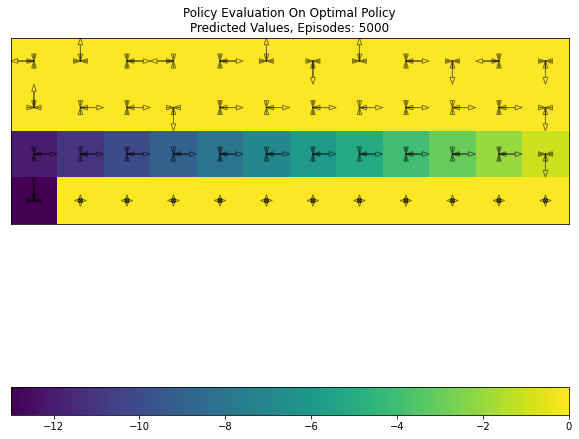

In [15]:
manager = Manager(env_info=env_info, 
                  agent_info=agent_info, 
                  experiment_name="Policy Evaluation On Optimal Policy")
manager.visualize(values=v, num_episodes=num_episodes)